<a href="https://colab.research.google.com/github/WoradeeKongthong/garbage_image_multiclass_classification/blob/main/garbage_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
from google.colab import files
import matplotlib.pyplot as plt
import os
import numpy as np
import glob
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend
#from sklearn.metrics import fbeta_score
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns

# Download dataset from kaggle
You need to have your kaggle API token.  
*   go to your kaggle account
*   scroll down and click "create new API token" button
*   upload your own kaggle.json to your colab

In [2]:
# Upload your kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samanthak","key":"fdd8007802a172c276f2336f2ca6a021"}'}

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d asdasdasasdas/garbage-classification
! unzip garbage-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/c

# Explore Data

## Check types of garbage images

In [4]:
dataset_path = '/content/Garbage classification/Garbage classification'
garbage_types = os.listdir(dataset_path)
garbage_types

['cardboard', 'plastic', 'glass', 'trash', 'metal', 'paper']

## Number of images in each folder


In [5]:
for garbage in garbage_types:
    print(garbage, ' : ', len(os.listdir(os.path.join(dataset_path, garbage))))

cardboard  :  403
plastic  :  482
glass  :  501
trash  :  137
metal  :  410
paper  :  594


## Show images and labels

In [6]:
# get image paths from folders
image_paths = glob.glob(dataset_path + '/**/*.jpg', recursive=True)

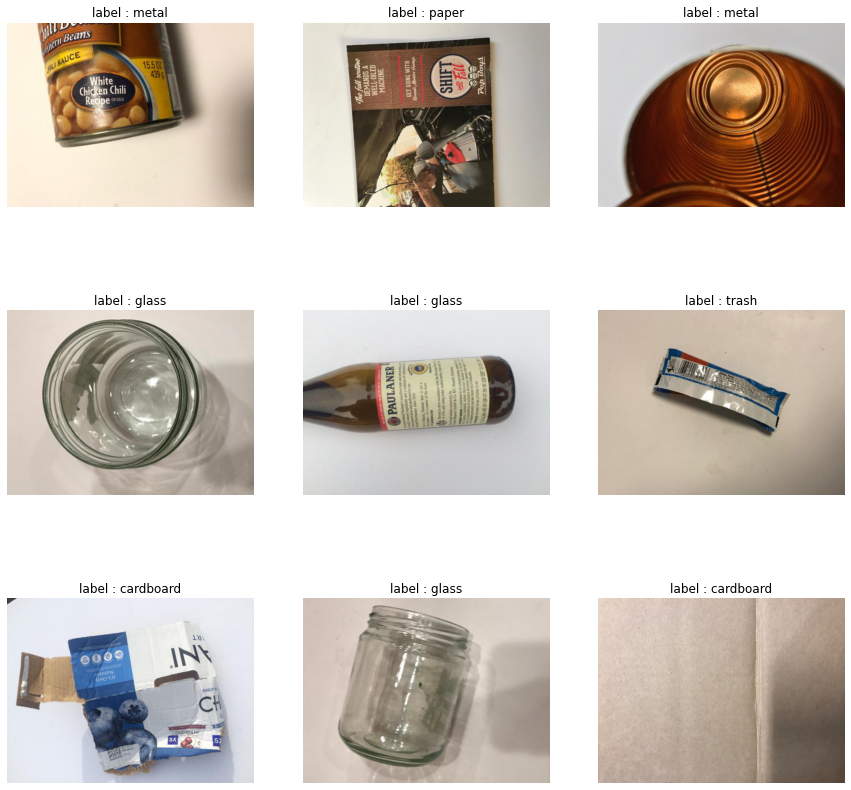

In [7]:
# show clean images
plt.figure(figsize=(15,15))
for i,path in enumerate(random.sample(image_paths, 9)):
  plt.subplot(3,3,i+1)
  img = plt.imread(path)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f'label : {path.split("/")[-2]}')
plt.show()

# Data preparation
Originally, we're given a folder of images with subfolder in type of garbage;  
cardboard, glass, metal, paper, plastic, and trash.  
And we're given the name of image files that are categorized into train, val, and test dataset  
as shown in 3 text files :  
- one-indexed-files-notrash_train.txt
- one-indexed-files-notrash_test.txt
- one-indexed-files-notrash_val.txt

In this preparation part, we're going to make folders (or directories) suitable for ingesting image data  
to our model with keras.preprocessing.image.ImageDataGenerator.

## Create dataset directories and subdirectories

In [7]:
# create new directory for dataset
data_path = os.path.join(os.getcwd(), 'dataset')
if not os.path.exists(data_path):
    os.makedirs(data_path)

# create train, test, and val directories
for folder in ['train', 'test', 'val']:
    target_path = os.path.join(data_path, folder)
    if not os.path.exists(target_path):
        os.makedirs(target_path)

In [8]:
# create cardboard, glass, metal, paper, plastic and trash directories in each directory
for dataset in ['train', 'test', 'val']:
    dataset_path = os.path.join(data_path, dataset)
    for folder in garbage_types:
        target_path = os.path.join(dataset_path, folder)
        if not os.path.exists(target_path):
            os.makedirs(target_path)

In [9]:
!ls -al dataset/train

total 32
drwxr-xr-x 8 root root 4096 Oct 11 01:19 .
drwxr-xr-x 5 root root 4096 Oct 11 01:19 ..
drwxr-xr-x 2 root root 4096 Oct 11 01:19 cardboard
drwxr-xr-x 2 root root 4096 Oct 11 01:19 glass
drwxr-xr-x 2 root root 4096 Oct 11 01:19 metal
drwxr-xr-x 2 root root 4096 Oct 11 01:19 paper
drwxr-xr-x 2 root root 4096 Oct 11 01:19 plastic
drwxr-xr-x 2 root root 4096 Oct 11 01:19 trash


In [10]:
!ls -al dataset/val

total 32
drwxr-xr-x 8 root root 4096 Oct 11 01:19 .
drwxr-xr-x 5 root root 4096 Oct 11 01:19 ..
drwxr-xr-x 2 root root 4096 Oct 11 01:19 cardboard
drwxr-xr-x 2 root root 4096 Oct 11 01:19 glass
drwxr-xr-x 2 root root 4096 Oct 11 01:19 metal
drwxr-xr-x 2 root root 4096 Oct 11 01:19 paper
drwxr-xr-x 2 root root 4096 Oct 11 01:19 plastic
drwxr-xr-x 2 root root 4096 Oct 11 01:19 trash


In [11]:
!ls -al dataset/test

total 32
drwxr-xr-x 8 root root 4096 Oct 11 01:19 .
drwxr-xr-x 5 root root 4096 Oct 11 01:19 ..
drwxr-xr-x 2 root root 4096 Oct 11 01:19 cardboard
drwxr-xr-x 2 root root 4096 Oct 11 01:19 glass
drwxr-xr-x 2 root root 4096 Oct 11 01:19 metal
drwxr-xr-x 2 root root 4096 Oct 11 01:19 paper
drwxr-xr-x 2 root root 4096 Oct 11 01:19 plastic
drwxr-xr-x 2 root root 4096 Oct 11 01:19 trash


## Occupy train, val and test directories

In [12]:
# occupy each directory of training dataset
source_path = '/content/Garbage classification/Garbage classification'
with open('one-indexed-files-notrash_train.txt') as file:
    temp = file.readlines()

temp = [item.split()[0] for item in temp]

for file in temp:
    for folder in garbage_types:
        if folder in file:
            src_img = os.path.join(source_path, folder+'/'+file)
            dst_img = os.path.join(data_path, 'train/'+folder+'/'+file)
            if not os.path.exists(dst_img):
                shutil.copyfile(src_img, dst_img)

In [13]:
# occupy each directory of validation dataset
source_path = '/content/Garbage classification/Garbage classification'
with open('one-indexed-files-notrash_val.txt') as file:
    temp = file.readlines()

temp = [item.split()[0] for item in temp]

for file in temp:
    for folder in garbage_types:
        if folder in file:
            src_img = os.path.join(source_path, folder+'/'+file)
            dst_img = os.path.join(data_path, 'val/'+folder+'/'+file)
            if not os.path.exists(dst_img):
                shutil.copyfile(src_img, dst_img)

In [14]:
# occupy each directory of test dataset
source_path = '/content/Garbage classification/Garbage classification'
with open('one-indexed-files-notrash_test.txt') as file:
    temp = file.readlines()

temp = [item.split()[0] for item in temp]

for file in temp:
    for folder in garbage_types:
        if folder in file:
            src_img = os.path.join(source_path, folder+'/'+file)
            dst_img = os.path.join(data_path, 'test/'+folder+'/'+file)
            if not os.path.exists(dst_img):
                shutil.copyfile(src_img, dst_img)

## Create data generator for train and validation sets (without data augmentation)
Possible augmentation : https://keras.io/api/preprocessing/image/#imagedatagenerator-class

In [16]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 32
train_iter = train_gen.flow_from_directory('dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical')
val_iter = val_gen.flow_from_directory('dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical')
test_iter = test_gen.flow_from_directory('dataset/test',target_size=(128, 128), batch_size=batch_size, class_mode='categorical')

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


## get labels_map

In [17]:
labels_map = dict((v,k) for k,v in train_iter.class_indices.items())
labels_map

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

# Create baseline model : simple CNN model

In [19]:
# I create F-beta score calculation in Keras to use as a metric 
# during training process instead of accuracy.

def fbeta(y_true, y_pred, beta=2):
  # clip predictions
  y_pdirred = backend.clip(y_pred, 0, 1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta, averaged across each class
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

In [20]:
# create function for plotting

def evaluate_model(history):
    # plot training and validation loss
    fig = plt.figure(figsize=(15,5))
    fig.add_subplot(121)
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    plt.title('Loss')

    # plot training and validation accuracy
    fig.add_subplot(122)
    plt.plot(history.history['fbeta'], color='blue', label='train')
    plt.plot(history.history['val_fbeta'], color='orange', label='val')
    plt.legend()
    plt.title('F-beta score')
    
    plt.show()
    
    # print model accuracy
    _, fbeta = model.evaluate(test_iter, steps=len(test_iter), verbose=0)
    print('Model F-beta score : ', fbeta)
    return fbeta

Epoch 1/50
56/56 [==============================] - 6s 105ms/step - loss: 16.1525 - fbeta: 0.2679 - val_loss: 1.7678 - val_fbeta: 0.4261
Epoch 2/50
56/56 [==============================] - 6s 101ms/step - loss: 1.7716 - fbeta: 0.3783 - val_loss: 3.3629 - val_fbeta: 0.3409
Epoch 3/50
56/56 [==============================] - 6s 100ms/step - loss: 1.7670 - fbeta: 0.4626 - val_loss: 1.4491 - val_fbeta: 0.4148
Epoch 4/50
56/56 [==============================] - 6s 100ms/step - loss: 0.8021 - fbeta: 0.6133 - val_loss: 1.2413 - val_fbeta: 0.4830
Epoch 5/50
56/56 [==============================] - 6s 100ms/step - loss: 0.6270 - fbeta: 0.6847 - val_loss: 1.9756 - val_fbeta: 0.3523
Epoch 6/50
56/56 [==============================] - 6s 101ms/step - loss: 0.5654 - fbeta: 0.7098 - val_loss: 1.5836 - val_fbeta: 0.4091
Epoch 7/50
56/56 [==============================] - 6s 100ms/step - loss: 0.4090 - fbeta: 0.8097 - val_loss: 1.4085 - val_fbeta: 0.4631
Epoch 8/50
56/56 [=============================

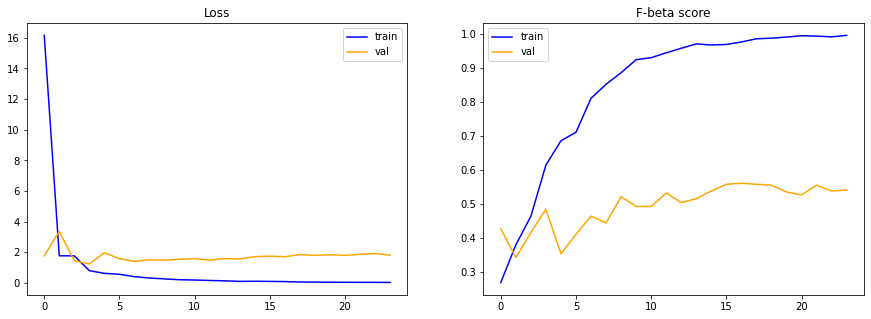

Model F-beta score :  0.5839285254478455


In [21]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    epochs=50,
                    callbacks = [es])

baseline_performance = evaluate_model(history)

# Improved models

## model 1 : baseline model + Dropout layers

Epoch 1/50
56/56 [==============================] - 6s 105ms/step - loss: 8.9101 - fbeta: 0.0954 - val_loss: 1.7303 - val_fbeta: 0.0028
Epoch 2/50
56/56 [==============================] - 6s 100ms/step - loss: 1.7010 - fbeta: 0.0335 - val_loss: 1.6563 - val_fbeta: 0.0312
Epoch 3/50
56/56 [==============================] - 6s 100ms/step - loss: 1.6161 - fbeta: 0.0625 - val_loss: 1.6368 - val_fbeta: 0.0625
Epoch 4/50
56/56 [==============================] - 6s 99ms/step - loss: 1.6265 - fbeta: 0.0787 - val_loss: 1.6037 - val_fbeta: 0.0597
Epoch 5/50
56/56 [==============================] - 6s 99ms/step - loss: 1.5232 - fbeta: 0.0854 - val_loss: 1.5813 - val_fbeta: 0.0597
Epoch 6/50
56/56 [==============================] - 6s 100ms/step - loss: 1.4755 - fbeta: 0.1122 - val_loss: 1.6074 - val_fbeta: 0.0710
Epoch 7/50
56/56 [==============================] - 6s 100ms/step - loss: 1.4686 - fbeta: 0.1479 - val_loss: 1.5575 - val_fbeta: 0.0852
Epoch 8/50
56/56 [==============================] 

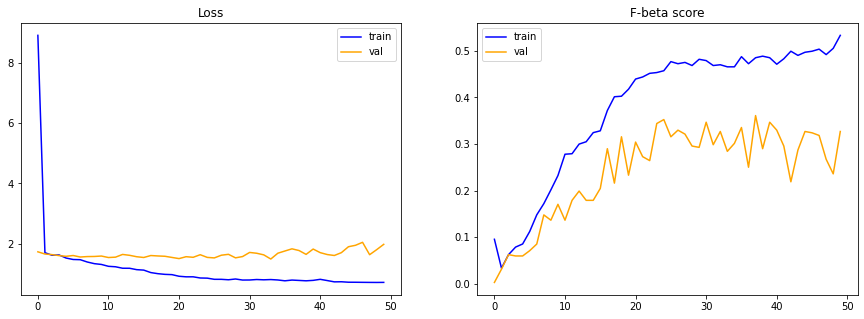

Model F-beta score :  0.36369043588638306


In [24]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    epochs=50)

# plot result
model1_performance = evaluate_model(history)

## model 2 : Baseline model + Data Augmentation

In [42]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(rescale=1./255,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical')

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


Epoch 1/100
89/89 [==============================] - 12s 125ms/step - loss: 13.0614 - fbeta: 0.1980 - val_loss: 2.0329 - val_fbeta: 0.3191
Epoch 2/100
89/89 [==============================] - 11s 122ms/step - loss: 2.1255 - fbeta: 0.2435 - val_loss: 1.6266 - val_fbeta: 0.3103
Epoch 3/100
89/89 [==============================] - 11s 124ms/step - loss: 1.8798 - fbeta: 0.2514 - val_loss: 1.7640 - val_fbeta: 0.3456
Epoch 4/100
89/89 [==============================] - 11s 124ms/step - loss: 1.7748 - fbeta: 0.2722 - val_loss: 1.8692 - val_fbeta: 0.2824
Epoch 5/100
89/89 [==============================] - 11s 124ms/step - loss: 1.7038 - fbeta: 0.2851 - val_loss: 1.3653 - val_fbeta: 0.3088
Epoch 6/100
89/89 [==============================] - 11s 123ms/step - loss: 1.3859 - fbeta: 0.2699 - val_loss: 1.3822 - val_fbeta: 0.3250
Epoch 7/100
89/89 [==============================] - 11s 124ms/step - loss: 1.3951 - fbeta: 0.2843 - val_loss: 1.3553 - val_fbeta: 0.3162
Epoch 8/100
89/89 [==============

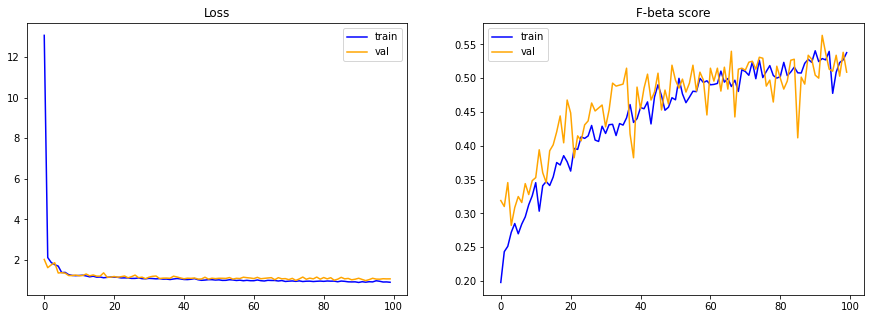

Model F-beta score :  0.5475637912750244


In [32]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    epochs=100)
# plot result
model2_performance = evaluate_model(history)

## model 3 : Baseline model + data augmentation + dropout layers

Epoch 1/100
89/89 [==============================] - 12s 125ms/step - loss: 6.9196 - fbeta: 0.0938 - val_loss: 1.7570 - val_fbeta: 0.0103
Epoch 2/100
89/89 [==============================] - 11s 124ms/step - loss: 1.7202 - fbeta: 0.0466 - val_loss: 1.7105 - val_fbeta: 0.0147
Epoch 3/100
89/89 [==============================] - 11s 124ms/step - loss: 1.6944 - fbeta: 0.0567 - val_loss: 1.6554 - val_fbeta: 0.0588
Epoch 4/100
89/89 [==============================] - 11s 124ms/step - loss: 1.6766 - fbeta: 0.0551 - val_loss: 1.7281 - val_fbeta: 0.0118
Epoch 5/100
89/89 [==============================] - 11s 124ms/step - loss: 1.6704 - fbeta: 0.0573 - val_loss: 1.6211 - val_fbeta: 0.0794
Epoch 6/100
89/89 [==============================] - 11s 124ms/step - loss: 1.6347 - fbeta: 0.0705 - val_loss: 1.6583 - val_fbeta: 0.0412
Epoch 7/100
89/89 [==============================] - 11s 124ms/step - loss: 1.7101 - fbeta: 0.0208 - val_loss: 1.7361 - val_fbeta: 0.0000e+00
Epoch 8/100
89/89 [===========

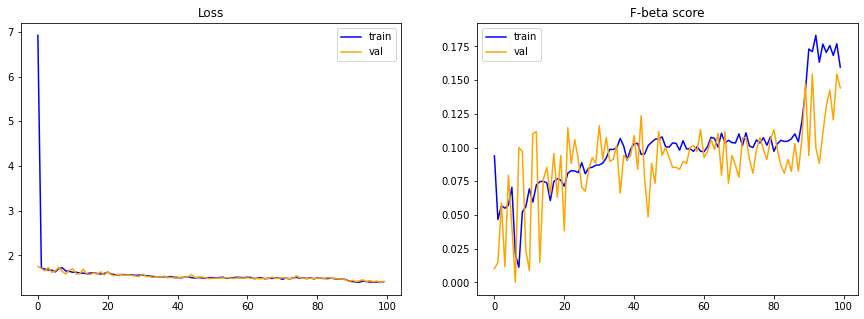

Model F-beta score :  0.16241297125816345


In [33]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# plot result
model3_performance = evaluate_model(history)

## model 4 : Baseline model + data augmentation + Dropout + one more convolutional layer

Epoch 1/200
89/89 [==============================] - 12s 129ms/step - loss: 5.6889 - fbeta: 0.0354 - val_loss: 1.7395 - val_fbeta: 0.0000e+00
Epoch 2/200
89/89 [==============================] - 11s 125ms/step - loss: 1.6789 - fbeta: 0.0017 - val_loss: 1.6172 - val_fbeta: 0.0059
Epoch 3/200
89/89 [==============================] - 11s 124ms/step - loss: 1.6047 - fbeta: 0.0455 - val_loss: 1.5972 - val_fbeta: 0.0235
Epoch 4/200
89/89 [==============================] - 11s 125ms/step - loss: 1.5030 - fbeta: 0.1022 - val_loss: 1.4034 - val_fbeta: 0.1471
Epoch 5/200
89/89 [==============================] - 11s 124ms/step - loss: 1.4259 - fbeta: 0.1669 - val_loss: 1.3471 - val_fbeta: 0.2176
Epoch 6/200
89/89 [==============================] - 11s 124ms/step - loss: 1.3588 - fbeta: 0.2093 - val_loss: 1.3973 - val_fbeta: 0.2515
Epoch 7/200
89/89 [==============================] - 11s 126ms/step - loss: 1.3365 - fbeta: 0.2287 - val_loss: 1.3400 - val_fbeta: 0.2618
Epoch 8/200
89/89 [===========

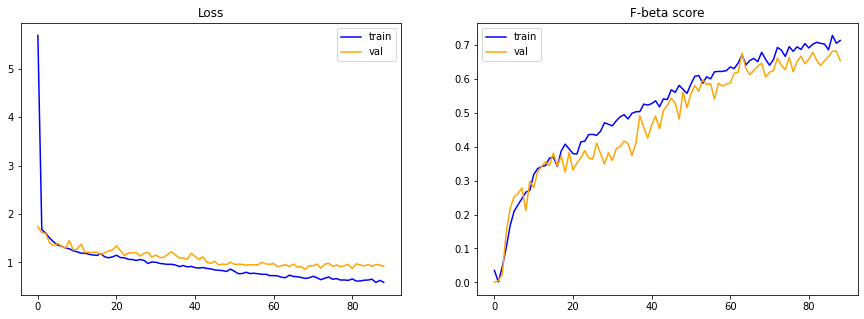

Model F-beta score :  0.6658931970596313


In [34]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# plot result
model4_performance = evaluate_model(history)

## model 5 : Baseline model + data augmentation + Dropout + 2 convolutional layers + one more dense layers

Epoch 1/200
89/89 [==============================] - 12s 128ms/step - loss: 2.3764 - fbeta: 0.0320 - val_loss: 1.6694 - val_fbeta: 0.0221
Epoch 2/200
89/89 [==============================] - 11s 126ms/step - loss: 1.5647 - fbeta: 0.0815 - val_loss: 1.5954 - val_fbeta: 0.0338
Epoch 3/200
89/89 [==============================] - 11s 126ms/step - loss: 1.4678 - fbeta: 0.1292 - val_loss: 1.5051 - val_fbeta: 0.0779
Epoch 4/200
89/89 [==============================] - 11s 126ms/step - loss: 1.4072 - fbeta: 0.1860 - val_loss: 1.4572 - val_fbeta: 0.1441
Epoch 5/200
89/89 [==============================] - 11s 126ms/step - loss: 1.3692 - fbeta: 0.2065 - val_loss: 1.3951 - val_fbeta: 0.2191
Epoch 6/200
89/89 [==============================] - 11s 126ms/step - loss: 1.3602 - fbeta: 0.2124 - val_loss: 1.3998 - val_fbeta: 0.2235
Epoch 7/200
89/89 [==============================] - 11s 125ms/step - loss: 1.2950 - fbeta: 0.2638 - val_loss: 1.3269 - val_fbeta: 0.2382
Epoch 8/200
89/89 [===============

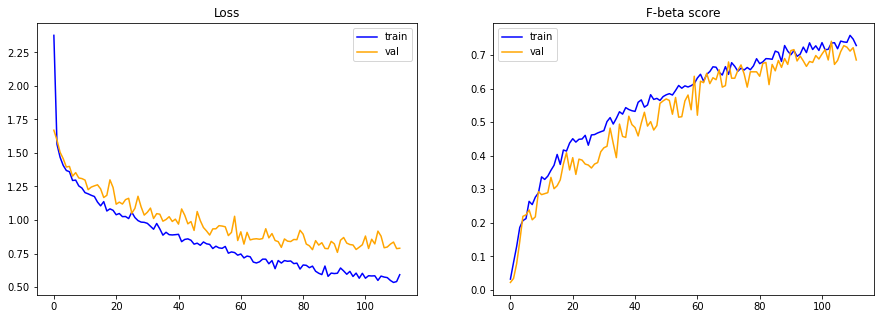

Model F-beta score :  0.679814338684082


In [35]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# plot result
model5_performance = evaluate_model(history)

## model 6 : 1 VGG block + data augmentation

Epoch 1/100
89/89 [==============================] - 12s 127ms/step - loss: 4.4873 - fbeta: 0.0163 - val_loss: 1.6474 - val_fbeta: 0.0118
Epoch 2/100
89/89 [==============================] - 11s 125ms/step - loss: 1.5908 - fbeta: 0.0388 - val_loss: 1.5348 - val_fbeta: 0.1088
Epoch 3/100
89/89 [==============================] - 11s 125ms/step - loss: 1.4869 - fbeta: 0.1081 - val_loss: 1.4756 - val_fbeta: 0.1471
Epoch 4/100
89/89 [==============================] - 11s 126ms/step - loss: 1.4221 - fbeta: 0.1694 - val_loss: 1.4075 - val_fbeta: 0.1985
Epoch 5/100
89/89 [==============================] - 11s 125ms/step - loss: 1.3887 - fbeta: 0.1862 - val_loss: 1.4118 - val_fbeta: 0.1721
Epoch 6/100
89/89 [==============================] - 11s 125ms/step - loss: 1.3450 - fbeta: 0.2275 - val_loss: 1.3815 - val_fbeta: 0.2985
Epoch 7/100
89/89 [==============================] - 11s 125ms/step - loss: 1.2801 - fbeta: 0.2635 - val_loss: 1.3655 - val_fbeta: 0.1735
Epoch 8/100
89/89 [===============

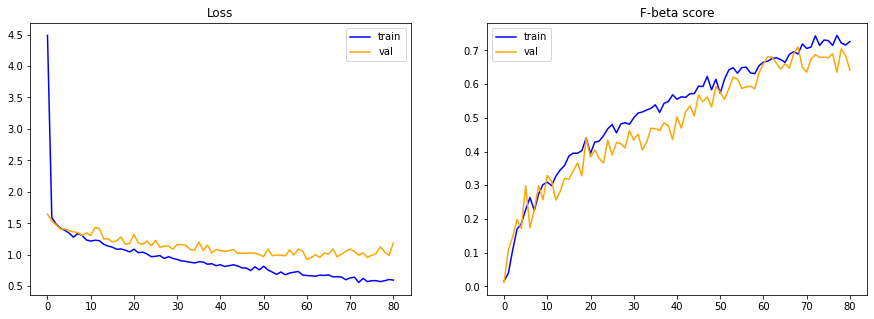

Model F-beta score :  0.6264500617980957


In [36]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model6_performance = evaluate_model(history)

## model 7 : 2 VGG blocks + data augmentation

Epoch 1/100
89/89 [==============================] - 12s 128ms/step - loss: 3.6063 - fbeta: 0.0163 - val_loss: 1.6675 - val_fbeta: 0.0029
Epoch 2/100
89/89 [==============================] - 11s 127ms/step - loss: 1.7135 - fbeta: 0.0067 - val_loss: 1.6847 - val_fbeta: 0.0000e+00
Epoch 3/100
89/89 [==============================] - 11s 126ms/step - loss: 1.5805 - fbeta: 0.0742 - val_loss: 1.6008 - val_fbeta: 0.0618
Epoch 4/100
89/89 [==============================] - 11s 125ms/step - loss: 1.5573 - fbeta: 0.0775 - val_loss: 1.5574 - val_fbeta: 0.1000
Epoch 5/100
89/89 [==============================] - 11s 126ms/step - loss: 1.5240 - fbeta: 0.0812 - val_loss: 1.5251 - val_fbeta: 0.0750
Epoch 6/100
89/89 [==============================] - 11s 126ms/step - loss: 1.4511 - fbeta: 0.1416 - val_loss: 1.4361 - val_fbeta: 0.1588
Epoch 7/100
89/89 [==============================] - 11s 127ms/step - loss: 1.3450 - fbeta: 0.2188 - val_loss: 1.3547 - val_fbeta: 0.2397
Epoch 8/100
89/89 [===========

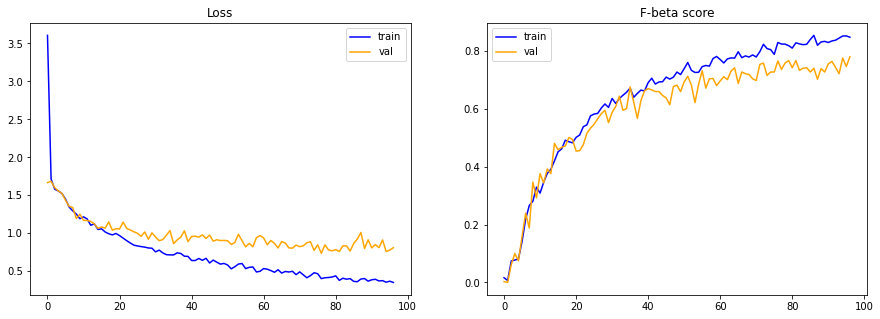

Model F-beta score :  0.7888630628585815


In [37]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model7_performance = evaluate_model(history)

## model 8 : 3 VGG blocks + data augmentation

Epoch 1/100
89/89 [==============================] - 12s 128ms/step - loss: 2.0472 - fbeta: 0.0320 - val_loss: 1.5049 - val_fbeta: 0.0603
Epoch 2/100
89/89 [==============================] - 11s 125ms/step - loss: 1.4732 - fbeta: 0.1087 - val_loss: 1.4051 - val_fbeta: 0.2044
Epoch 3/100
89/89 [==============================] - 11s 127ms/step - loss: 1.4069 - fbeta: 0.1669 - val_loss: 1.3923 - val_fbeta: 0.1397
Epoch 4/100
89/89 [==============================] - 11s 126ms/step - loss: 1.3456 - fbeta: 0.1913 - val_loss: 1.4574 - val_fbeta: 0.2632
Epoch 5/100
89/89 [==============================] - 11s 126ms/step - loss: 1.2921 - fbeta: 0.2413 - val_loss: 1.2694 - val_fbeta: 0.2912
Epoch 6/100
89/89 [==============================] - 11s 126ms/step - loss: 1.2897 - fbeta: 0.2514 - val_loss: 1.1923 - val_fbeta: 0.3338
Epoch 7/100
89/89 [==============================] - 11s 127ms/step - loss: 1.1947 - fbeta: 0.3160 - val_loss: 1.2288 - val_fbeta: 0.3397
Epoch 8/100
89/89 [===============

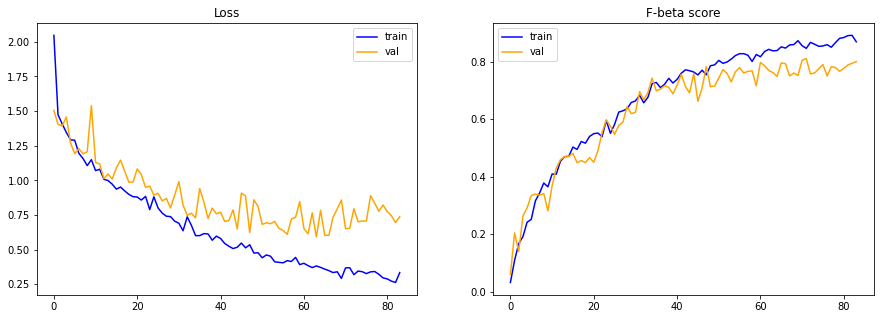

Model F-beta score :  0.7679813504219055


In [38]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(128,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model8_performance = evaluate_model(history)

## model 9 : 2 VGG blocks + data augmentation + dropout layers

Epoch 1/200
89/89 [==============================] - 12s 128ms/step - loss: 2.6091 - fbeta: 0.0129 - val_loss: 1.7014 - val_fbeta: 0.0000e+00
Epoch 2/200
89/89 [==============================] - 11s 126ms/step - loss: 1.7043 - fbeta: 0.0140 - val_loss: 1.6824 - val_fbeta: 0.0000e+00
Epoch 3/200
89/89 [==============================] - 11s 127ms/step - loss: 1.5590 - fbeta: 0.0781 - val_loss: 1.6335 - val_fbeta: 0.0397
Epoch 4/200
89/89 [==============================] - 11s 127ms/step - loss: 1.6219 - fbeta: 0.0511 - val_loss: 1.6745 - val_fbeta: 0.0000e+00
Epoch 5/200
89/89 [==============================] - 11s 126ms/step - loss: 1.6124 - fbeta: 0.0494 - val_loss: 1.5505 - val_fbeta: 0.0676
Epoch 6/200
89/89 [==============================] - 11s 126ms/step - loss: 1.4972 - fbeta: 0.1149 - val_loss: 1.4868 - val_fbeta: 0.0500
Epoch 7/200
89/89 [==============================] - 11s 126ms/step - loss: 1.4479 - fbeta: 0.1638 - val_loss: 1.3930 - val_fbeta: 0.1721
Epoch 8/200
89/89 [===

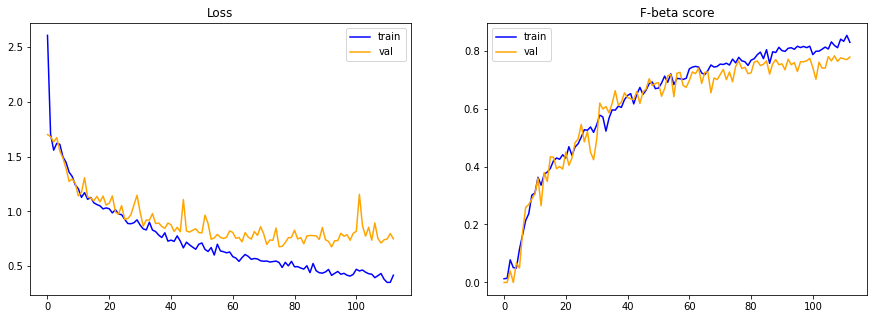

Model F-beta score :  0.7587006092071533


In [44]:
# create model
model = Sequential()
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(32,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(128,128,3)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# result
model9_performance = evaluate_model(history)

## model 10 : pre-trained VGG16 as an integrated feature extractor 

Epoch 1/100
89/89 [==============================] - 13s 134ms/step - loss: 1.3554 - fbeta: 0.2927 - val_loss: 0.9756 - val_fbeta: 0.4265
Epoch 2/100
89/89 [==============================] - 11s 129ms/step - loss: 1.0691 - fbeta: 0.4194 - val_loss: 0.8746 - val_fbeta: 0.5294
Epoch 3/100
89/89 [==============================] - 11s 130ms/step - loss: 0.9538 - fbeta: 0.5070 - val_loss: 0.8699 - val_fbeta: 0.5647
Epoch 4/100
89/89 [==============================] - 11s 129ms/step - loss: 0.8751 - fbeta: 0.5534 - val_loss: 0.7609 - val_fbeta: 0.6368
Epoch 5/100
89/89 [==============================] - 12s 130ms/step - loss: 0.8634 - fbeta: 0.5629 - val_loss: 0.8062 - val_fbeta: 0.6206
Epoch 6/100
89/89 [==============================] - 12s 130ms/step - loss: 0.8253 - fbeta: 0.5882 - val_loss: 0.7619 - val_fbeta: 0.6324
Epoch 7/100
89/89 [==============================] - 12s 129ms/step - loss: 0.8232 - fbeta: 0.6028 - val_loss: 0.7836 - val_fbeta: 0.6294
Epoch 8/100
89/89 [===============

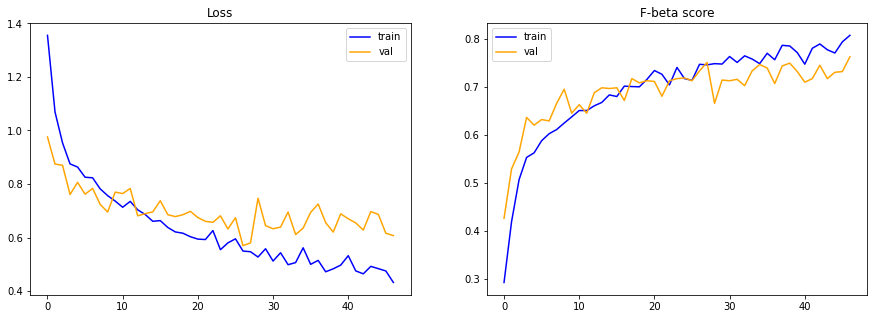

Model F-beta score :  0.7865428328514099


In [48]:
# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.1)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(100, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.1)(class1)
output = Dense(6, activation='softmax')(dropout2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model10_performance = evaluate_model(history)

## model 11 : pre-trained VGG16 as an integrated feature extractor + more Dense layer

Epoch 1/100
89/89 [==============================] - 12s 132ms/step - loss: 1.4310 - fbeta: 0.2528 - val_loss: 1.0769 - val_fbeta: 0.4088
Epoch 2/100
89/89 [==============================] - 11s 129ms/step - loss: 1.1372 - fbeta: 0.3851 - val_loss: 0.9626 - val_fbeta: 0.4162
Epoch 3/100
89/89 [==============================] - 12s 130ms/step - loss: 1.0281 - fbeta: 0.4508 - val_loss: 0.8692 - val_fbeta: 0.5250
Epoch 4/100
89/89 [==============================] - 11s 128ms/step - loss: 1.0006 - fbeta: 0.4817 - val_loss: 0.8732 - val_fbeta: 0.5397
Epoch 5/100
89/89 [==============================] - 11s 129ms/step - loss: 0.9059 - fbeta: 0.5486 - val_loss: 0.9155 - val_fbeta: 0.5559
Epoch 6/100
89/89 [==============================] - 12s 129ms/step - loss: 0.9102 - fbeta: 0.5576 - val_loss: 0.7788 - val_fbeta: 0.6382
Epoch 7/100
89/89 [==============================] - 12s 129ms/step - loss: 0.8543 - fbeta: 0.5722 - val_loss: 0.8080 - val_fbeta: 0.5985
Epoch 8/100
89/89 [===============

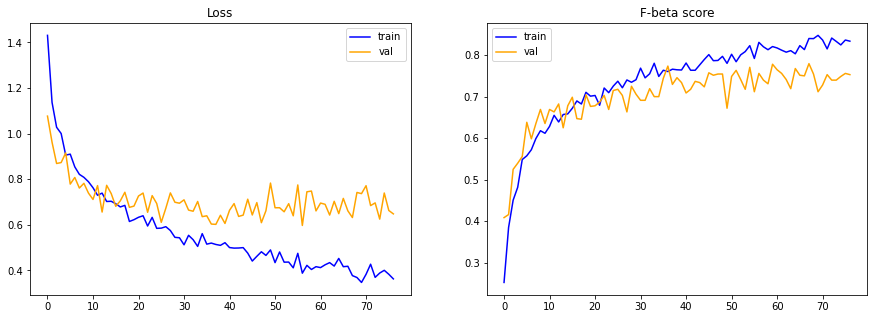

Model F-beta score :  0.7703015804290771


In [49]:
# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.1)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.1)(class1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.1)(class2)
output = Dense(6, activation='softmax')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model11_performance = evaluate_model(history)

## model 12 : pre-trained VGG16 as an integrated feature extractor + vgg16.preprocess_input

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 13s 133ms/step - loss: 4.1662 - fbeta: 0.4949 - val_loss: 1.7483 - val_fbeta: 0.6206
Epoch 2/100
89/89 [==============================] - 12s 131ms/step - loss: 1.8703 - fbeta: 0.5719 - val_loss: 0.9395 - val_fbeta: 0.6706
Epoch 3/100
89/89 [==============================] - 12s 133ms/step - loss: 1.3821 - fbeta: 0.5562 - val_loss: 0.8603 - val_fbeta: 0.6441
Epoch 4/100
89/89 [==============================] - 12s 130ms/step - loss: 1.0262 - fbeta: 0.5980 - val_loss: 0.6914 - val_fbeta: 0.6971
Epoch 5/100
89/89 [==============================] - 12s 130ms/step - loss: 0.9329 - fbeta: 0.6222 - val_loss: 0.7794 - val_fbeta: 0.6750
Epoch 6/100
89/89 [==============================] - 12s 132ms/step - loss: 0.8206 - fbeta: 0.6548 - val_loss: 0.6666 - val_fbeta: 0.6971
Epoch 7/100
89/89 [=============================

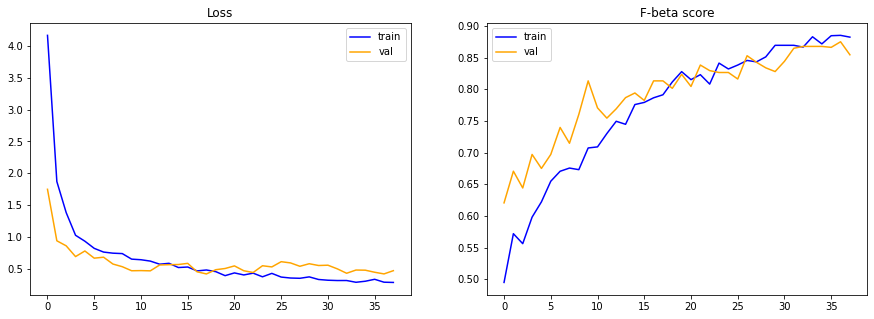

Model F-beta score :  0.8051043152809143


In [225]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.1)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.1)(class1)
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.1)(class2)
class3 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
dropout4 = Dropout(0.1)(class3)
output = Dense(6, activation='softmax')(dropout4)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model12_performance = evaluate_model(history)

## model 13 : model 12 with setting last block as trainable

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 13s 141ms/step - loss: 3.7217 - fbeta: 0.0247 - val_loss: 1.6799 - val_fbeta: 0.0118
Epoch 2/100
89/89 [==============================] - 12s 137ms/step - loss: 1.7416 - fbeta: 0.0096 - val_loss: 1.6592 - val_fbeta: 0.0250
Epoch 3/100
89/89 [==============================] - 12s 139ms/step - loss: 1.7007 - fbeta: 0.0185 - val_loss: 1.5997 - val_fbeta: 0.1000
Epoch 4/100
89/89 [==============================] - 12s 140ms/step - loss: 1.6781 - fbeta: 0.0371 - val_loss: 1.7118 - val_fbeta: 0.1353
Epoch 5/100
89/89 [==============================] - 12s 139ms/step - loss: 1.6506 - fbeta: 0.0469 - val_loss: 1.5957 - val_fbeta: 0.1309
Epoch 6/100
89/89 [==============================] - 12s 139ms/step - loss: 1.6109 - fbeta: 0.0697 - val_loss: 1.7395 - val_fbeta: 0.0412
Epoch 7/100
89/89 [=============================

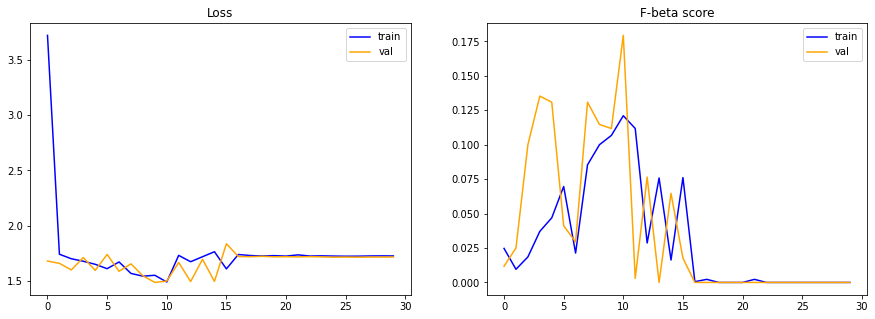

Model F-beta score :  0.0


In [226]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers[:-13]:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.1)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.1)(class1)
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.1)(class2)
class3 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
dropout4 = Dropout(0.1)(class3)
output = Dense(6, activation='softmax')(dropout4)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model13_performance = evaluate_model(history)

## model 14 : pre-trained ResNet50 as an integrated feature extractor with preprocess_input

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 15s 144ms/step - loss: 3.4982 - fbeta: 0.5949 - val_loss: 1.6339 - val_fbeta: 0.7103
Epoch 2/100
89/89 [==============================] - 12s 136ms/step - loss: 1.2544 - fbeta: 0.7376 - val_loss: 1.0255 - val_fbeta: 0.7676
Epoch 3/100
89/89 [==============================] - 12s 134ms/step - loss: 1.0201 - fbeta: 0.7719 - val_loss: 1.0399 - val_fbeta: 0.7794
Epoch 4/100
89/89 [==============================] - 12s 133ms/step - loss: 0.6668 - fbeta: 0.8267 - val_loss: 0.6350 - val_fbeta: 0.8324
Epoch 5/100
89/89 [==============================] - 12s 133ms/step - loss: 0.5664 - fbeta: 0.8244 - val_loss: 0.6505 - val_fbeta: 0.8191
Epoch 6/100
89/89 [==============================] - 12s 137ms/step - loss: 0.4689 - fbeta: 0.8478 - val_loss: 0.7216 - val_fbeta: 0.8074
Epoch 7/100
89/89 [=============================

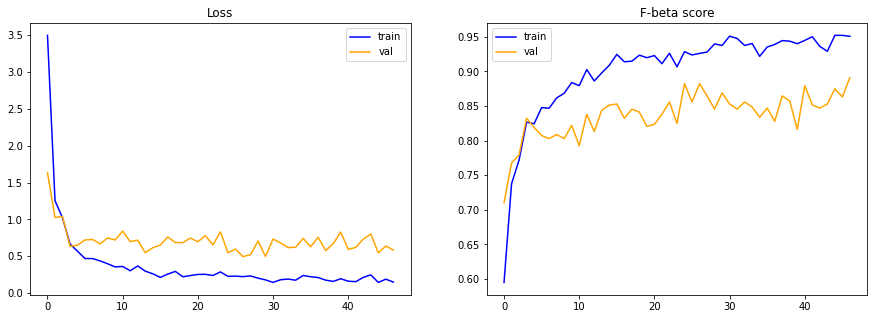

Model F-beta score :  0.8793503046035767


In [221]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# create model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(200, activation='relu', kernel_initializer='he_uniform')(flat1)
class2 = Dense(100, activation='relu', kernel_initializer='he_uniform')(class1)
output = Dense(6, activation='softmax')(class2)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model14_perf = evaluate_model(history)

## model 15 : model 14 with more dense layer and dropout layers


Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/100
89/89 [==============================] - 31s 147ms/step - loss: 4.2015 - fbeta: 0.4233 - val_loss: 0.9008 - val_fbeta: 0.5926
Epoch 2/100
89/89 [==============================] - 12s 133ms/step - loss: 1.4704 - fbeta: 0.4601 - val_loss: 0.8808 - val_fbeta: 0.5353
Epoch 3/100
89/89 [==============================] - 12s 135ms/step - loss: 1.1011 - fbeta: 0.5351 - val_loss: 0.7370 - val_fbeta: 0.6765
Epoch 4/100
89/89 [==============================] - 12s 135ms/step - loss: 0.9476 - fbeta: 0.5699 - val_loss: 0.7349 - val_fbeta: 0.6706
Epoch 5/100
89/89 [==============================] - 12s 134ms/step - loss: 0.9189 - fbeta: 0.6028 - val_loss: 0.6297 - val_fbeta: 0.7206
Epoch 6/100
89/89 [==============================] - 12s 134ms/step - loss: 0.8346 - fbeta: 0.6360 - val_loss: 0.6923 - val_fbeta: 0.6882
Epoch 7/100
89/89 [=============================

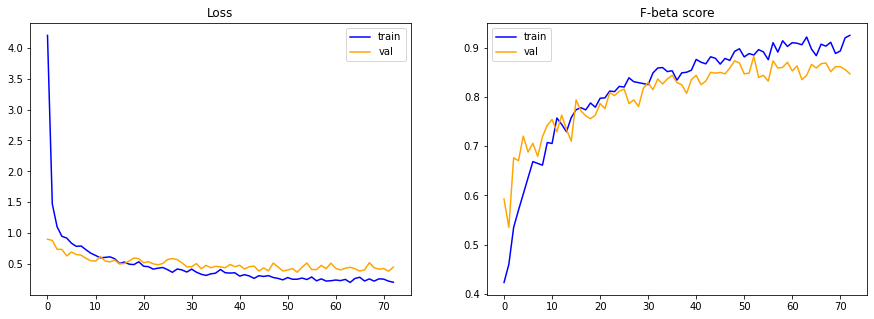

Model F-beta score :  0.8399071097373962


In [21]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# create model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout1 = Dropout(0.2)(class1)
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.2)(class2)
class3 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class3)
output = Dense(6, activation='softmax')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=100)

# result
model15_perf = evaluate_model(history)

## model 16 : model 15 with longer training and more patience

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 15s 145ms/step - loss: 4.8929 - fbeta: 0.4011 - val_loss: 1.0174 - val_fbeta: 0.5147
Epoch 2/200
89/89 [==============================] - 12s 135ms/step - loss: 1.4449 - fbeta: 0.4756 - val_loss: 0.8938 - val_fbeta: 0.5265
Epoch 3/200
89/89 [==============================] - 12s 134ms/step - loss: 1.1862 - fbeta: 0.5163 - val_loss: 0.7716 - val_fbeta: 0.6000
Epoch 4/200
89/89 [==============================] - 12s 134ms/step - loss: 1.0071 - fbeta: 0.5581 - val_loss: 0.7494 - val_fbeta: 0.5926
Epoch 5/200
89/89 [==============================] - 12s 135ms/step - loss: 0.9058 - fbeta: 0.6042 - val_loss: 0.6092 - val_fbeta: 0.6882
Epoch 6/200
89/89 [==============================] - 12s 134ms/step - loss: 0.8762 - fbeta: 0.6309 - val_loss: 0.5882 - val_fbeta: 0.7250
Epoch 7/200
89/89 [=============================

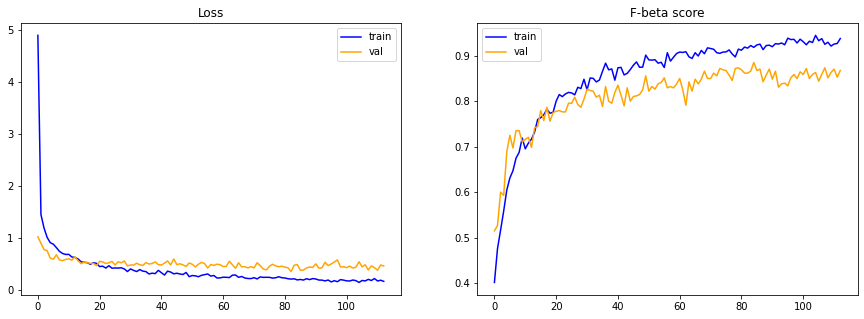

Model F-beta score :  0.8515080213546753


In [22]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# create model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout1 = Dropout(0.2)(class1)
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.2)(class2)
class3 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class3)
output = Dense(6, activation='softmax')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# result
model16_perf = evaluate_model(history)

## model 17 : model 12 with longer training and more patience

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 13s 134ms/step - loss: 6.2108 - fbeta: 0.3812 - val_loss: 1.5711 - val_fbeta: 0.5956
Epoch 2/200
89/89 [==============================] - 12s 129ms/step - loss: 2.4090 - fbeta: 0.4649 - val_loss: 1.3327 - val_fbeta: 0.4956
Epoch 3/200
89/89 [==============================] - 12s 132ms/step - loss: 1.6782 - fbeta: 0.4461 - val_loss: 1.0081 - val_fbeta: 0.4471
Epoch 4/200
89/89 [==============================] - 12s 130ms/step - loss: 1.2891 - fbeta: 0.4756 - val_loss: 0.8830 - val_fbeta: 0.4926
Epoch 5/200
89/89 [==============================] - 12s 131ms/step - loss: 1.2304 - fbeta: 0.4725 - val_loss: 0.8915 - val_fbeta: 0.5250
Epoch 6/200
89/89 [==============================] - 12s 130ms/step - loss: 1.1356 - fbeta: 0.5059 - val_loss: 0.8624 - val_fbeta: 0.5382
Epoch 7/200
89/89 [=============================

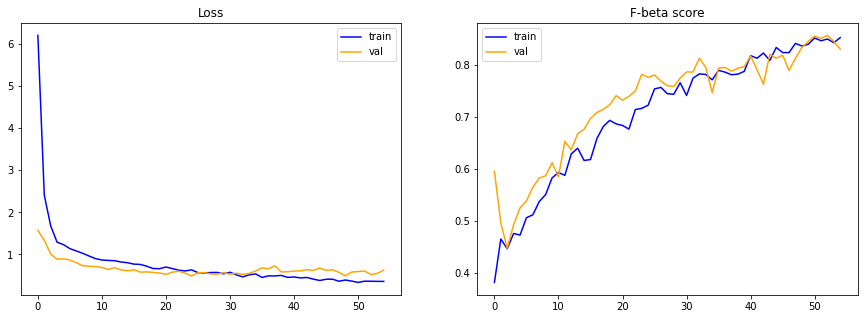

Model F-beta score :  0.7958235740661621


In [43]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class2)
class3 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout3)
dropout4 = Dropout(0.2)(class3)
output = Dense(6, activation='softmax')(dropout4)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# result
model17_performance = evaluate_model(history)

## model 18 : model 17 + add more Dense layer

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 13s 134ms/step - loss: 6.0435 - fbeta: 0.3421 - val_loss: 1.1808 - val_fbeta: 0.4765
Epoch 2/200
89/89 [==============================] - 12s 131ms/step - loss: 2.0684 - fbeta: 0.4003 - val_loss: 1.1355 - val_fbeta: 0.3956
Epoch 3/200
89/89 [==============================] - 12s 130ms/step - loss: 1.5457 - fbeta: 0.3778 - val_loss: 1.0113 - val_fbeta: 0.3985
Epoch 4/200
89/89 [==============================] - 12s 130ms/step - loss: 1.3097 - fbeta: 0.4326 - val_loss: 0.8693 - val_fbeta: 0.5000
Epoch 5/200
89/89 [==============================] - 12s 130ms/step - loss: 1.1459 - fbeta: 0.4767 - val_loss: 0.7535 - val_fbeta: 0.5794
Epoch 6/200
89/89 [==============================] - 12s 131ms/step - loss: 1.1048 - fbeta: 0.4955 - val_loss: 0.7665 - val_fbeta: 0.5441
Epoch 7/200
89/89 [=============================

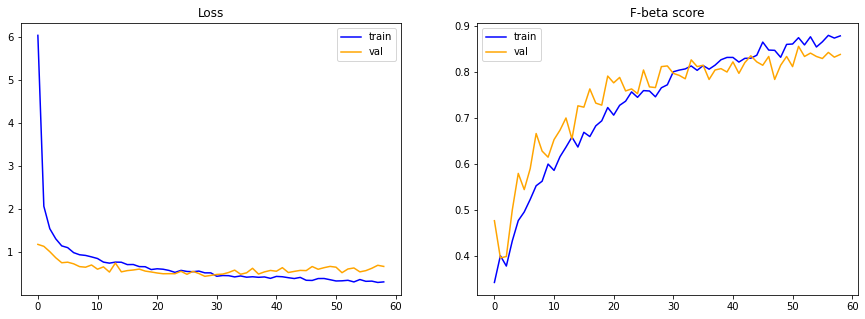

Model F-beta score :  0.8375869393348694


In [45]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
class2 = Dense(256, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class2)
class3 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout3)
dropout4 = Dropout(0.2)(class3)
class4 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout4)
dropout5 = Dropout(0.2)(class4)
output = Dense(6, activation='softmax')(dropout5)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# result
model18_performance = evaluate_model(history)

## model 19 : model 18 + one more Dense layer

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/200
89/89 [==============================] - 13s 137ms/step - loss: 8.0831 - fbeta: 0.4065 - val_loss: 1.1889 - val_fbeta: 0.6235
Epoch 2/200
89/89 [==============================] - 12s 133ms/step - loss: 2.2609 - fbeta: 0.4736 - val_loss: 0.8954 - val_fbeta: 0.5926
Epoch 3/200
89/89 [==============================] - 12s 131ms/step - loss: 1.4838 - fbeta: 0.5242 - val_loss: 0.8412 - val_fbeta: 0.6191
Epoch 4/200
89/89 [==============================] - 12s 131ms/step - loss: 1.2560 - fbeta: 0.5199 - val_loss: 0.8623 - val_fbeta: 0.6029
Epoch 5/200
89/89 [==============================] - 12s 132ms/step - loss: 1.1562 - fbeta: 0.5632 - val_loss: 0.7693 - val_fbeta: 0.5750
Epoch 6/200
89/89 [==============================] - 12s 130ms/step - loss: 1.0425 - fbeta: 0.5615 - val_loss: 0.6531 - val_fbeta: 0.6456
Epoch 7/200
89/89 [=============================

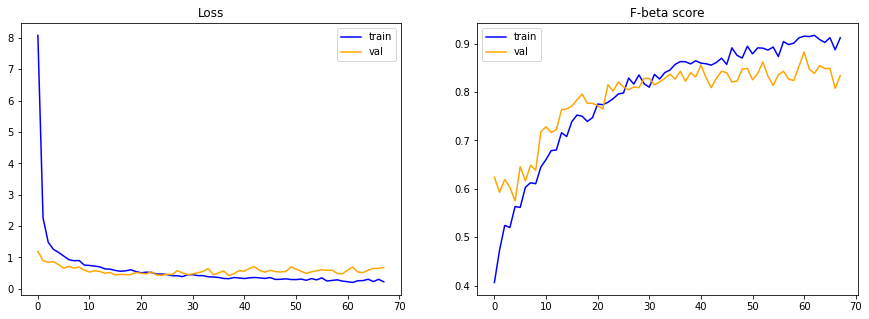

Model F-beta score :  0.830626368522644


In [46]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# load VGG16 model
model = VGG16(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
dropout1 = Dropout(0.2)(model.layers[-1].output)
flat1 = Flatten()(dropout1)
class1 = Dense(1024, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout2 = Dropout(0.2)(class1)
class2 = Dense(512, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class2)
class3 = Dense(256, activation='relu', kernel_initializer='he_uniform')(dropout3)
dropout4 = Dropout(0.2)(class3)
class4 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout4)
dropout5 = Dropout(0.2)(class4)
class5 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout5)
dropout6 = Dropout(0.2)(class5)
output = Dense(6, activation='softmax')(dropout5)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[fbeta])

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es],
                    epochs=200)

# result
model18_performance = evaluate_model(history)

# Error diagnostic

In [23]:
# print labels_map
labels_map

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [24]:
# create inverse label map
inv_labels_map = {cls:num for num,cls in labels_map.items()}
inv_labels_map

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [25]:
# get image paths from train folder
train_image_paths = glob.glob('dataset/train/**/*.jpg', recursive=True)

In [26]:
# create X, y for training set
X_train = []
y_train = []
for path in train_image_paths :
  img_array = img_to_array(load_img(path, target_size=(128, 128)))
  X_train.append(img_array)
  label = inv_labels_map[path.split('/')[-2]]
  y_train.append(label)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [27]:
# get prediction
y_pred = model.predict(X_train)

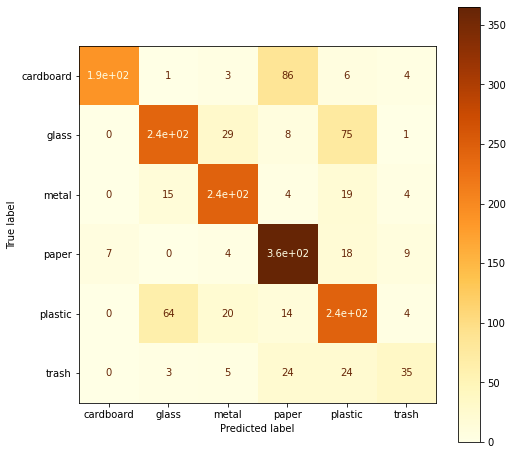

In [29]:
# plot confusion matrix of model prediction
conf_mat = confusion_matrix(y_train, np.argmax(y_pred, axis=1))
fig, ax = plt.subplots(figsize=(8, 8))
dist = ConfusionMatrixDisplay(conf_mat, display_labels=labels_map.values())
dist.plot(cmap='YlOrBr', ax=ax)
plt.show()

In [31]:
# create dataframe of source, label and prediction to ease showing the error
data = {'paths':train_image_paths,
        'label':[labels_map[y] for y in y_train.tolist()],
        'prediction':[labels_map[y] for y in np.argmax(y_pred, axis=1).tolist()]}
df = pd.DataFrame(data)
# df.head()

In [32]:
def show_sample_prediction(label, prediction):
  error_df = df[(df['label']==label) & (df['prediction']==prediction)]
  sample_idx = random.sample(range(len(error_df)), 25)

  plt.figure(figsize=(15,15))
  for i, idx in enumerate(sample_idx):
    plt.subplot(5,5,i+1)
    img = plt.imread(error_df.iloc[idx]['paths'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"label : {error_df.iloc[idx]['label']}\nprediction : {error_df.iloc[idx]['prediction']}")
  plt.show()

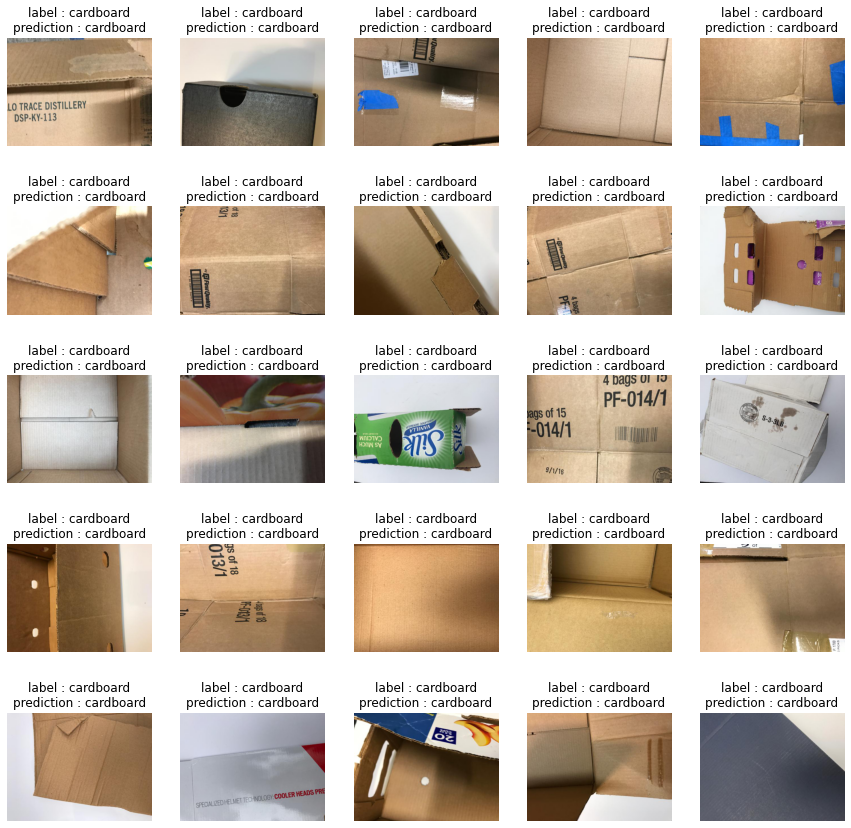

In [33]:
show_sample_prediction('cardboard','cardboard')

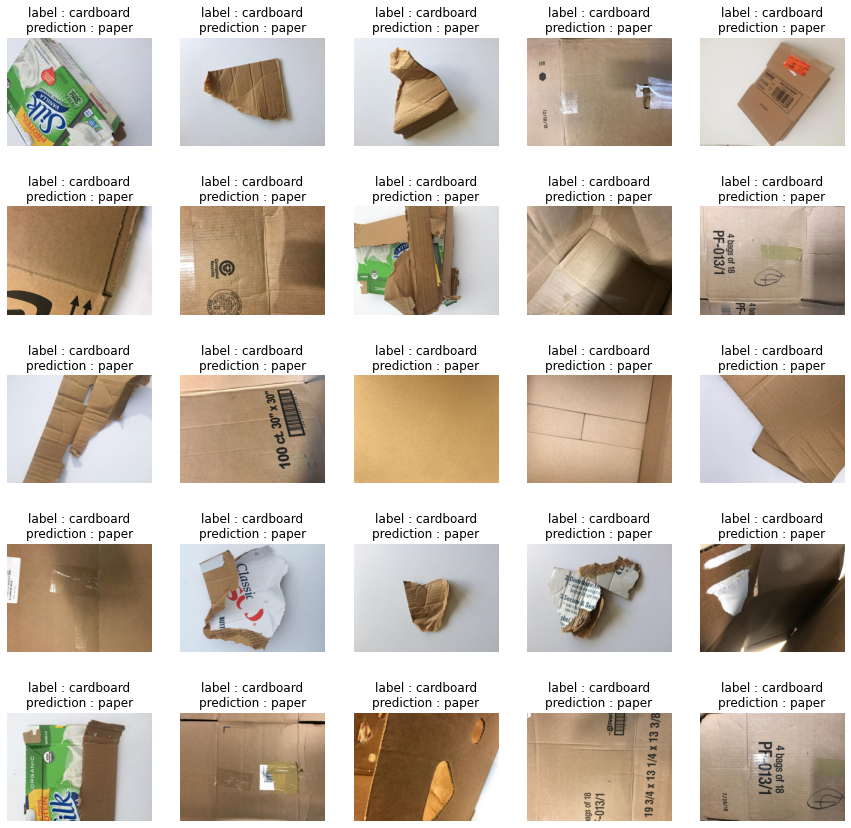

In [35]:
show_sample_prediction('cardboard','paper')

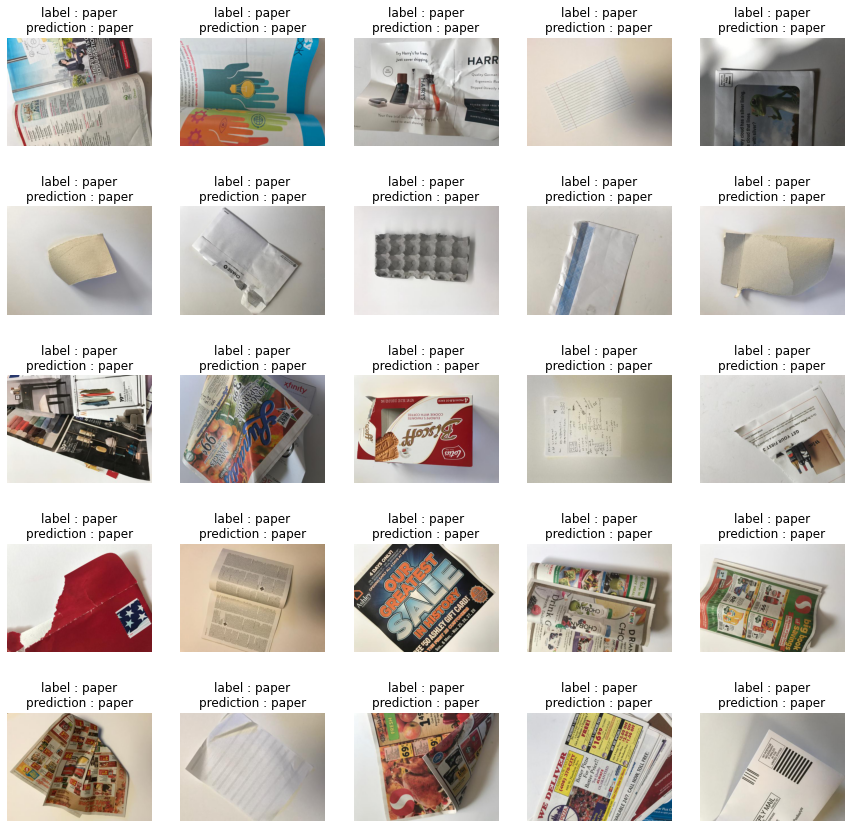

In [34]:
show_sample_prediction('paper','paper')

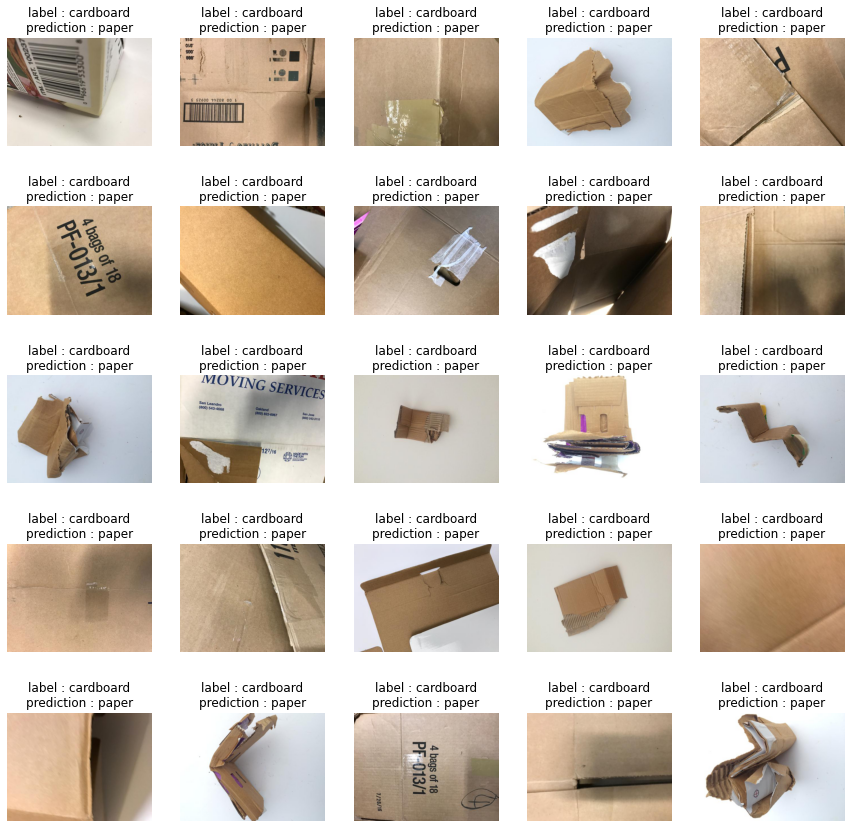

In [240]:
show_sample_prediction('cardboard','paper')

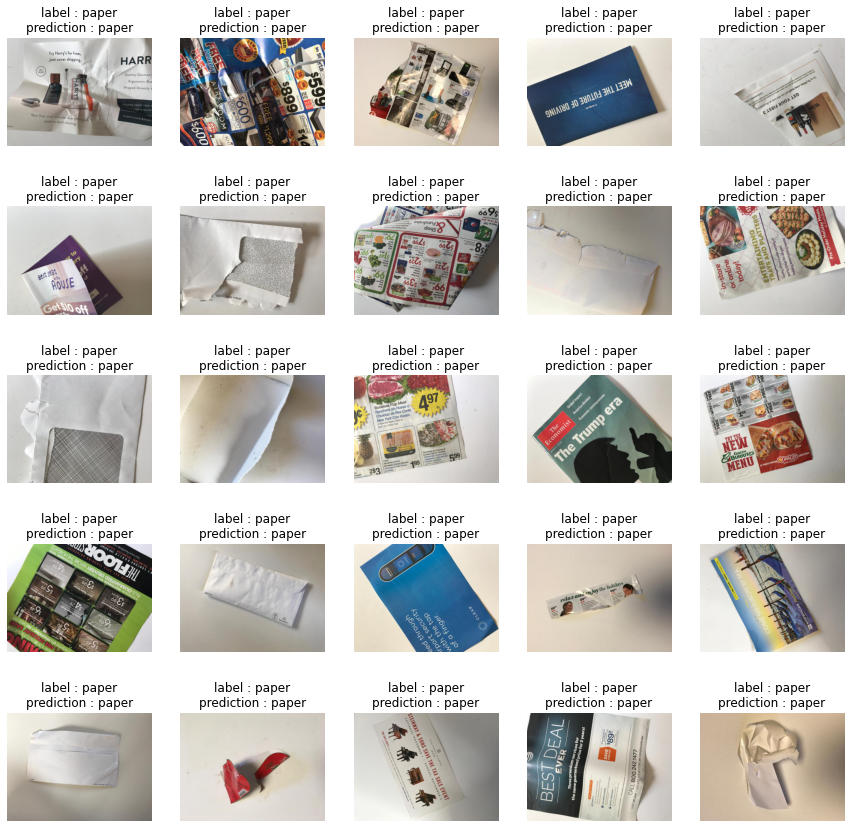

In [241]:
show_sample_prediction('paper','paper')

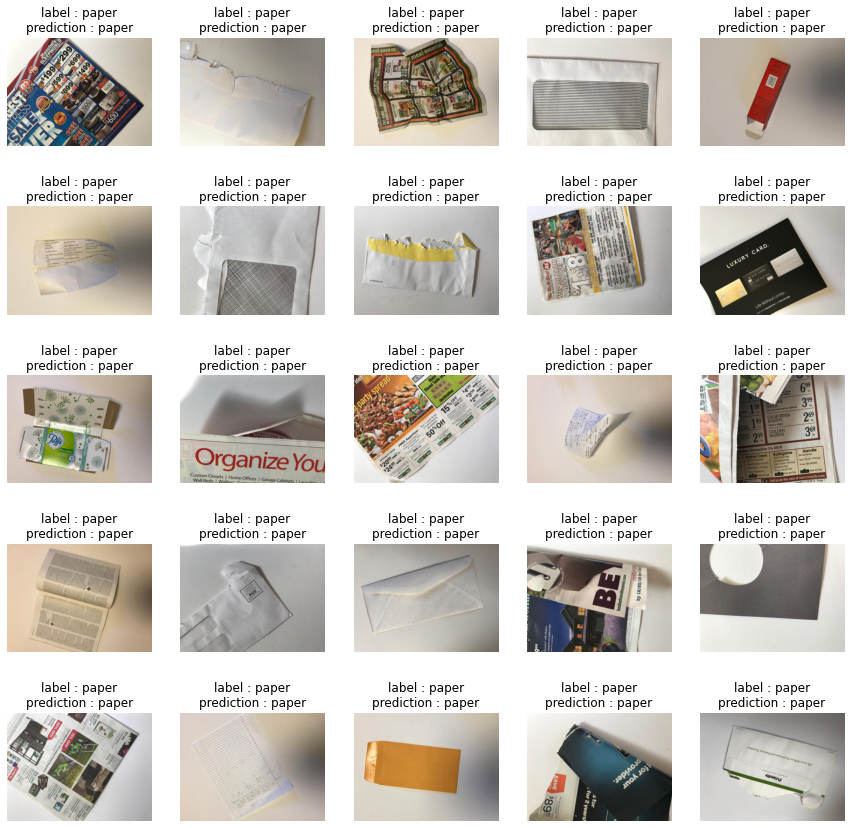

In [36]:
show_sample_prediction('paper','paper')

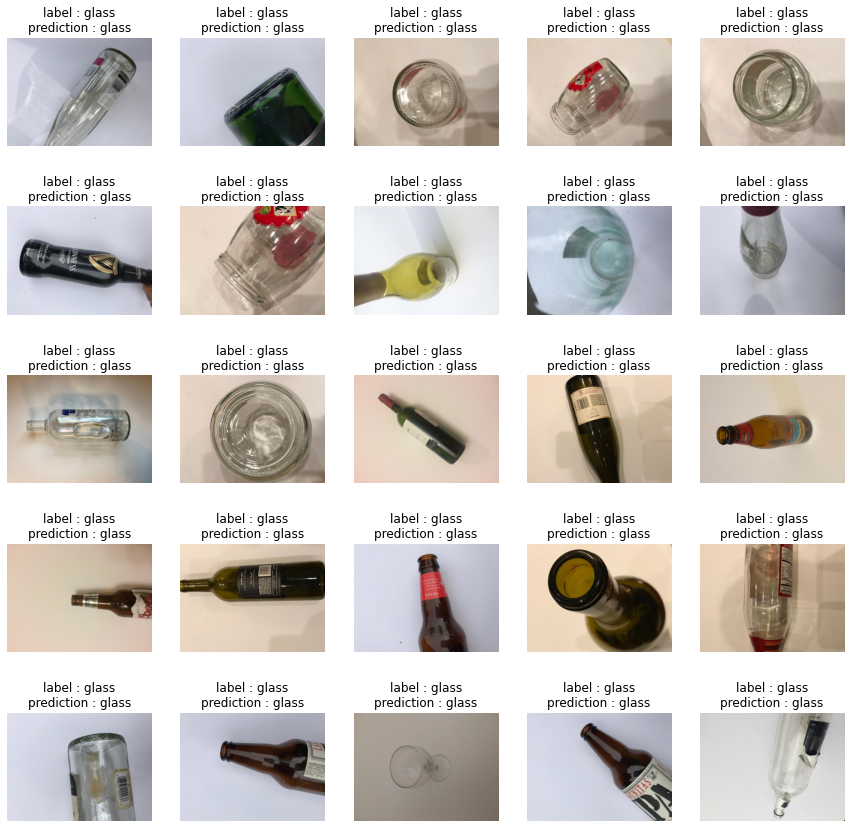

In [37]:
show_sample_prediction('glass','glass')

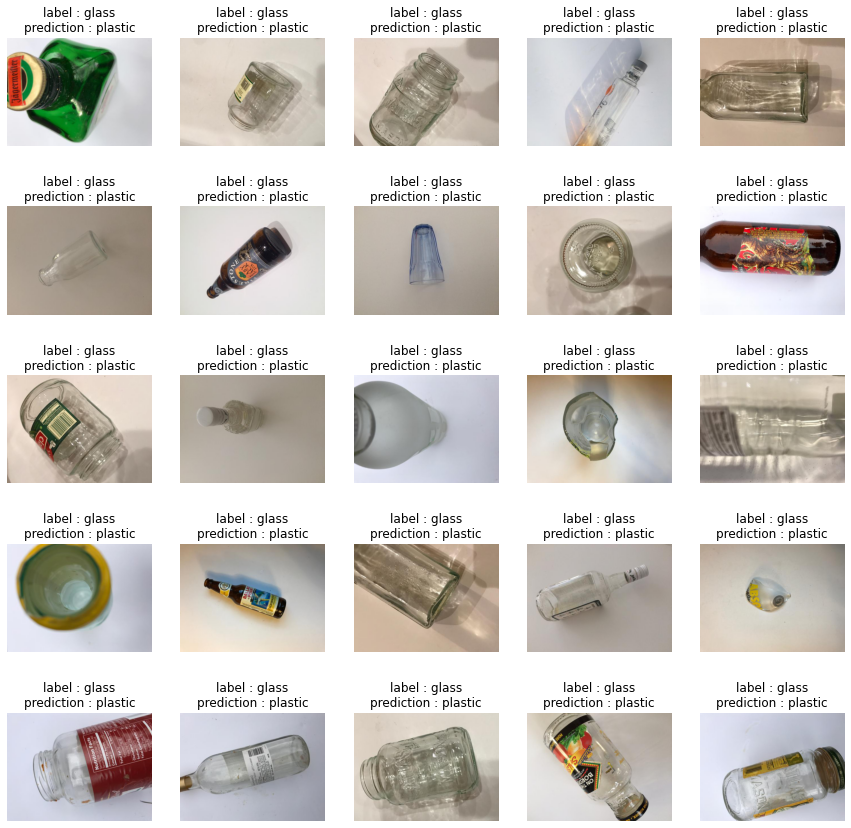

In [38]:
show_sample_prediction('glass','plastic')

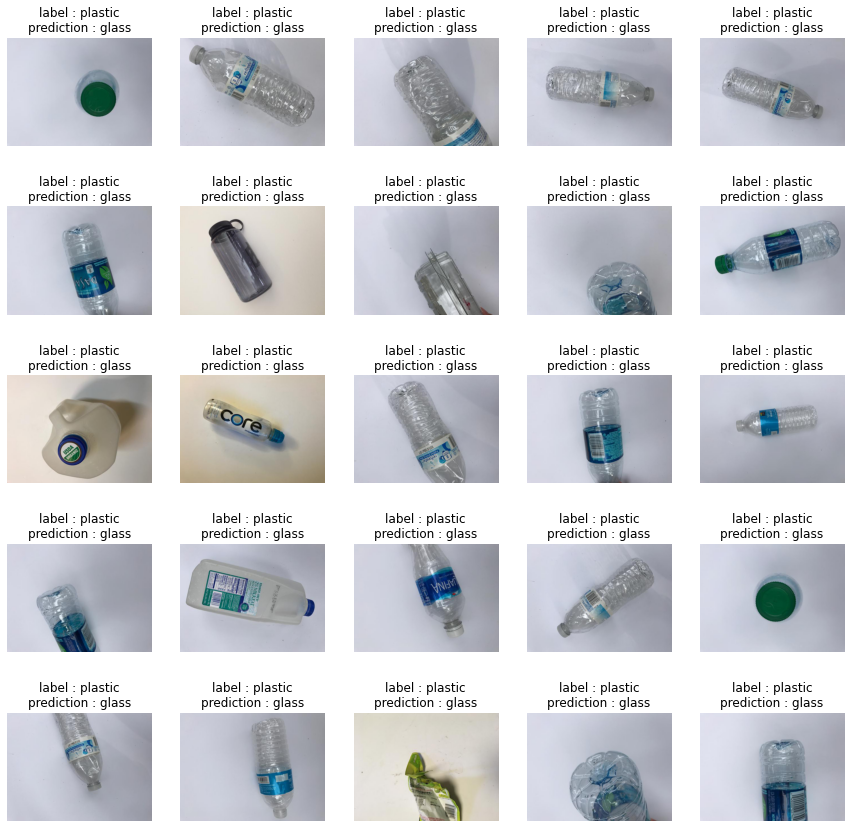

In [39]:
show_sample_prediction('plastic','glass')

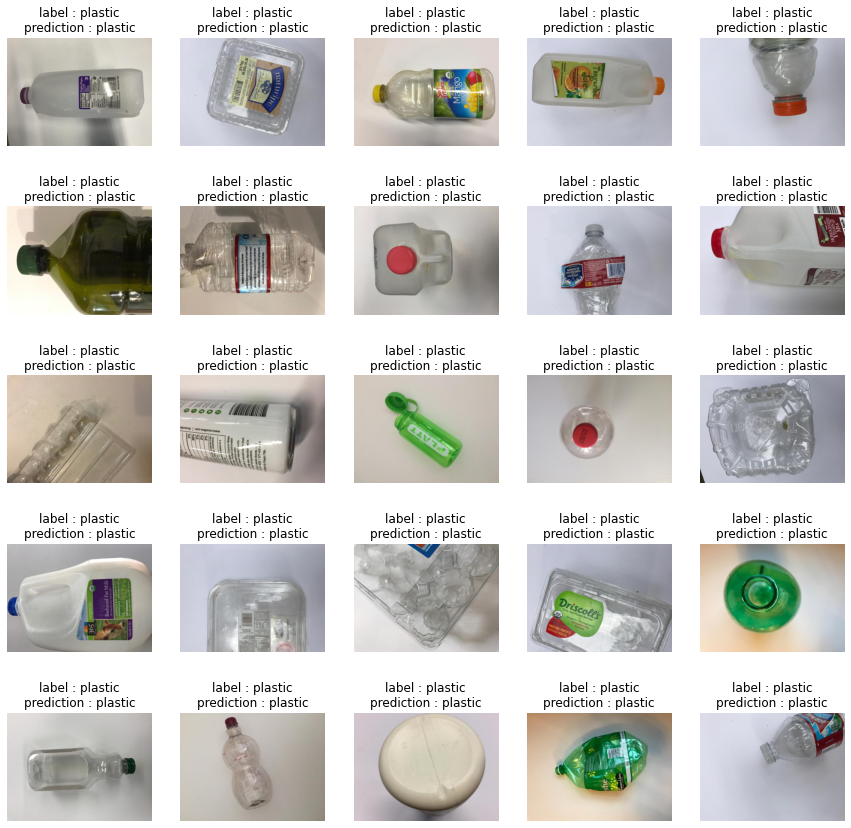

In [40]:
show_sample_prediction('plastic','plastic')

# Finalize Model : model 15 (pre-trained ResNet50)

In [47]:
# create data generator without data augmentation
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               vertical_flip=True,
                               horizontal_flip=True)
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20
train_iter = train_gen.flow_from_directory('/content/dataset/train',target_size=(128, 128), batch_size=batch_size, class_mode='categorical',seed=1)
val_iter = val_gen.flow_from_directory('/content/dataset/val',target_size=(128, 128), batch_size=batch_size, class_mode='categorical', seed=1)
test_iter = test_gen.flow_from_directory('/content/dataset/test',target_size=(128, 128), batch_size=1, class_mode='categorical', seed=1)

# create model
model = ResNet50(include_top=False, input_shape=(128,128,3))
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(256, activation='relu', kernel_initializer='he_uniform')(flat1)
dropout1 = Dropout(0.2)(class1)
class2 = Dense(128, activation='relu', kernel_initializer='he_uniform')(dropout1)
dropout2 = Dropout(0.2)(class2)
class3 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout2)
dropout3 = Dropout(0.2)(class3)
output = Dense(6, activation='softmax')(dropout3)
# define model
model = Model(inputs=model.inputs, outputs=output)

# compile model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# create early stopping object
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# create model checkpoint to save the model
mc = ModelCheckpoint('garbage_clf.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# train model
history = model.fit(train_iter,
                    steps_per_epoch=len(train_iter), 
                    validation_data=val_iter,
                    validation_steps=len(val_iter),
                    callbacks=[es, mc],
                    epochs=300)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.
Epoch 1/300
89/89 [==============================] - 15s 143ms/step - loss: 4.6978 - val_loss: 1.0888

Epoch 00001: val_loss improved from inf to 1.08885, saving model to garbage_clf.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/300
89/89 [==============================] - 12s 134ms/step - loss: 1.6356 - val_loss: 0.9118

Epoch 00002: val_loss improved from 1.08885 to 0.91178, saving model to garbage_clf.h5
Epoch 3/300
89/89 [==============================] - 12s 133ms/step - loss: 1.2744 - val_loss: 0.8097

Epoch 00003: val_loss improved from 0.91178 to 0.80974, saving model to garbage_clf.h5
Epoch 4/300
89/89 [==============================] - 12s 134ms/step - loss: 1.0984 - val_loss: 0.8225

Epoch 00004: val_loss did not improve from 0.80974
Epoch 5/300
89/89 [==============================] - 12s 134ms/step - loss: 0.9946 - val_loss: 0.7214

Epoch 00005: val_loss improved from 0.80974 to 0.72136, saving model to garbage_clf.h5
Epoch 6/300
89/89 [==============================] - 12s 135ms/step - loss: 0.8901 - val_loss: 0.7212

Epoch 00006: val_loss improved from 0.72136 to 0.72122, saving model to garbage_clf.h5
Epoch 7/300
89/89 [==============================] - 12s 133ms/step - loss: 0.8239 - v

# Save model and weight saparagely

In [50]:
model = load_model('garbage_clf.h5')

In [51]:
# save model
model_json = model.to_json()
with open("garbage_clf_model.json", "w") as json_file:
    json_file.write(model_json)
# save weights to HDFS
model.save_weights("garbage_clf_weights.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [52]:
from google.colab import files
files.download('garbage_clf_model.json')
files.download('garbage_clf_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>